In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict

In [50]:
dataframe = pd.read_csv('https://www.lombacovid.it/story.csv')
timeseries = dataframe['ospedalizzati_story']

timeseries.describe()

count     700.000000
mean     2308.878571
std      2365.576297
min       155.000000
25%       472.750000
50%      1197.500000
75%      3866.000000
max      9340.000000
Name: ospedalizzati_story, dtype: float64

# ARIMA

In [51]:
def compareSummaryAndVariance(order_1, order_2, fitted_timeseries):

    model = ARIMA(endog=fitted_timeseries, order=order_1)
    res_a = model.fit()
    print(res_a.summary())

    model = ARIMA(endog=fitted_timeseries, order=order_2)
    res_b = model.fit()
    print(res_b.summary())

    fig, ax = plt.subplots(1, 2, sharey=True, figsize=(12, 6))
    ax[0].plot(res_a.resid.values, alpha=0.7, label='variance={:.3f}'.format(np.std(res_a.resid.values)))
    ax[0].set_title(f"ARIMA({order_1[0]},{order_1[1]},{order_1[2]})")
    ax[0].legend()
    ax[1].plot(res_b.resid.values, alpha=0.7, label='variance={:.3f}'.format(np.std(res_b.resid.values)))
    ax[1].set_title(f"ARIMA({order_2[0]},{order_2[1]},{order_2[2]})")
    ax[1].legend()

    return

In [52]:
def ADFTest(timeseries):

    print(" > Is the data stationary ?")
    adftest = kpss(timeseries, 'ct')
    print("Test statistic = {:.3f}".format(adftest[0]))
    print("P-value = {:.3f}".format(adftest[1]))
    print("Critical values :")
    for k, v in adftest[3].items():
        print("\t{}: {}".format(k, v))

    return

Tipically the logged timeseries is more stationary

Text(0.5, 1.0, 'Logged data (deflated)')

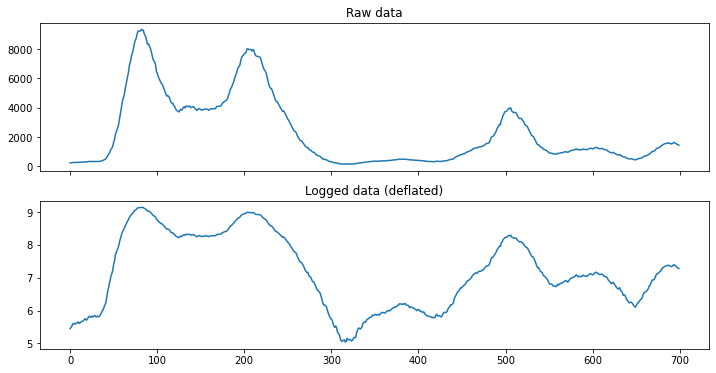

In [53]:
fig, ax = plt.subplots(2, sharex=True, figsize=(12,6))
ax[0].plot(timeseries.values)
ax[0].set_title("Raw data")
ax[1].plot(np.log(timeseries.values))
ax[1].set_title("Logged data (deflated)")

The logged series seems to be more flat, but is it stationary ? Let’s compute a KPSS test to check this:

In [54]:
ADFTest(np.log(timeseries))

 > Is the data stationary ?
Test statistic = 0.278
P-value = 0.010
Critical values :
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216


/Users/stefanomartire/miniforge3/envs/lombacovid/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


The logged timeseries is non-stationary too because "the test statistic is above the critical values", so:

In [55]:
fitted_timeseries = timeseries

Rule 1 : If the series has positive autocorrelations out to a high number of lags, then it probably needs a higher order of differencing.

Rule 2 : If the lag-1 autocorrelation is zero or negative, or the autocorrelations are all small and patternless, then the series does not need a higher order of differencing. If the lag-1 autocorrelation is -0.5 or more negative, the series may be overdifferenced.

/Users/stefanomartire/miniforge3/envs/lombacovid/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


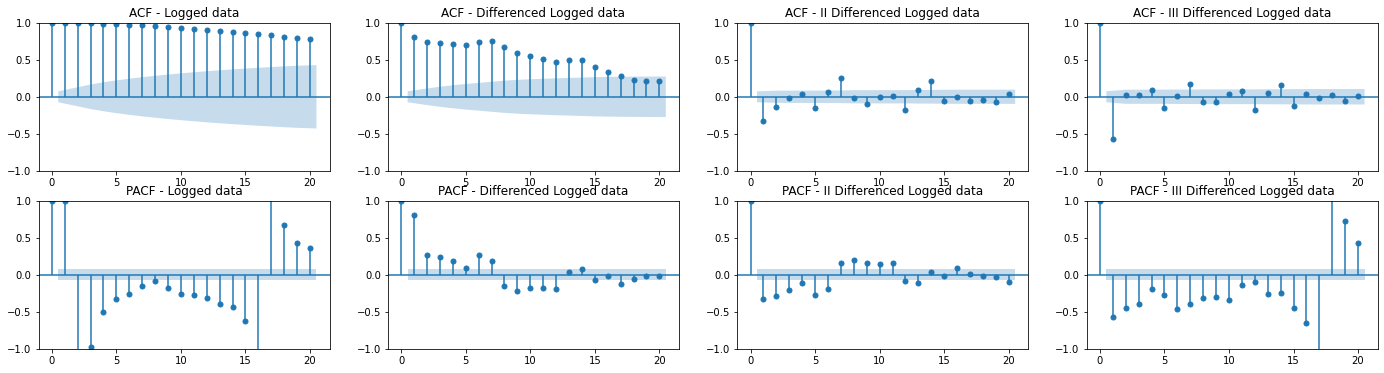

In [56]:
fig, ax = plt.subplots(2, 4, figsize=(24,6))
first_diff = (fitted_timeseries - fitted_timeseries.shift()).dropna()
second_diff = (first_diff- first_diff.shift()).dropna()
third_diff = (second_diff - second_diff.shift()).dropna()
ax[0, 0] = plot_acf(fitted_timeseries, ax=ax[0, 0], lags=20, title="ACF - Logged data")
ax[1, 0] = plot_pacf(fitted_timeseries, ax=ax[1, 0], lags=20, title="PACF - Logged data")
ax[0, 1] = plot_acf(first_diff , ax=ax[0, 1], lags=20, title="ACF - Differenced Logged data")
ax[1, 1] = plot_pacf(first_diff, ax=ax[1, 1], lags=20, title="PACF - Differenced Logged data")
ax[0, 2] = plot_acf(second_diff , ax=ax[0, 2], lags=20, title="ACF - II Differenced Logged data")
ax[1, 2] = plot_pacf(second_diff, ax=ax[1, 2], lags=20, title="PACF - II Differenced Logged data")
ax[0, 3] = plot_acf(third_diff , ax=ax[0, 3], lags=20, title="ACF - III Differenced Logged data")
ax[1, 3] = plot_pacf(third_diff, ax=ax[1, 3], lags=20, title="PACF - III Differenced Logged data")

The “ACF — Logged data” chart shows non-stationary data, characterized by the slow linear decay in the spikes (cf rule 1 above). Adding a 3rd order difference gives a single negative spike at lag value 1. According to rule#2, we don’t need to differentiate the series any further. Let’s check our results by comparing a (0, 2, 0) and a (0, 3, 0) ARIMA model:

                                SARIMAX Results                                
Dep. Variable:     ospedalizzati_story   No. Observations:                  700
Model:                  ARIMA(0, 2, 0)   Log Likelihood               -3846.071
Date:                 Mon, 01 Aug 2022   AIC                           7694.142
Time:                         22:34:22   BIC                           7698.690
Sample:                              0   HQIC                          7695.901
                                 - 700                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      3577.3766    100.181     35.709      0.000    3381.025    3773.729
Ljung-Box (L1) (Q):                  77.33   Jarque-Bera (JB):               819.23
Prob(Q):                              0

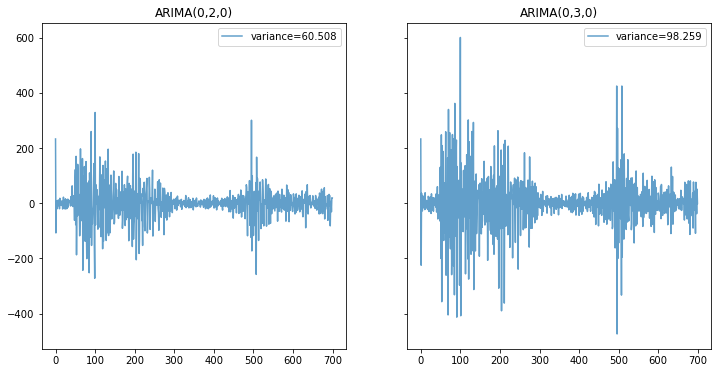

In [57]:
compareSummaryAndVariance((0,2,0), (0,3,0), fitted_timeseries)

So actually 2nd order is the best.

We now need to choose the Moving-Average order. This is done by looking at the differenced series. If the lag-1 autocorrelation of the differenced series ACF is negative, and/or there is a sharp cutoff, then choose a MA order of 1. If instead we observe autocorrelations at higher lags, and by looking at the autocorrelation residuals of our (0,2,1) model, we still observe these spikes, we can increase our MA order... though is usually not recommended to go beyond 2!

                                SARIMAX Results                                
Dep. Variable:     ospedalizzati_story   No. Observations:                  700
Model:                  ARIMA(0, 2, 1)   Log Likelihood               -3758.263
Date:                 Mon, 01 Aug 2022   AIC                           7520.527
Time:                         22:34:23   BIC                           7529.623
Sample:                              0   HQIC                          7524.043
                                 - 700                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6304      0.020    -31.964      0.000      -0.669      -0.592
sigma2      2779.5988     76.472     36.348      0.000    2629.716    2929.482
Ljung-Box (L1) (Q):                   5.37  

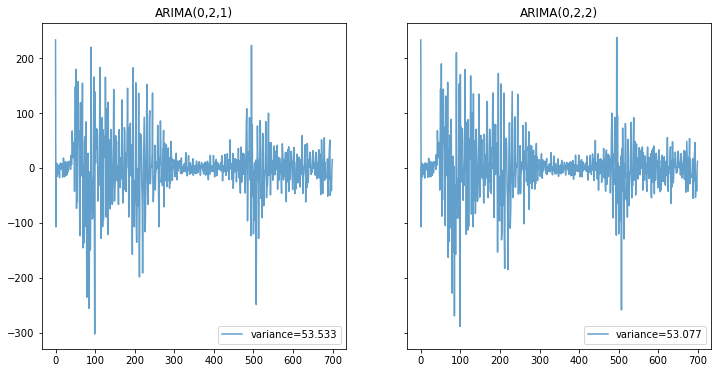

In [58]:
compareSummaryAndVariance((0,2,1), (0,2,2), fitted_timeseries)

you should add an AR term if the lag-1 autocorrelation of the differenced series PACF is negative, and/or there is a sharp cutoff, then choose a AR order of 1. Actually our PACF of the differenced series shows twelve negative spikes, meaning we could in theory push our AR order up to 12

/Users/stefanomartire/miniforge3/envs/lombacovid/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                SARIMAX Results                                
Dep. Variable:     ospedalizzati_story   No. Observations:                  700
Model:                  ARIMA(6, 2, 2)   Log Likelihood               -3683.317
Date:                 Mon, 01 Aug 2022   AIC                           7384.635
Time:                         22:34:23   BIC                           7425.569
Sample:                              0   HQIC                          7400.460
                                 - 700                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6495      0.039     16.799      0.000       0.574       0.725
ar.L2         -0.4457      0.034    -13.138      0.000      -0.512      -0.379
ar.L3         -0.1282      0.032     -4.058 

/Users/stefanomartire/miniforge3/envs/lombacovid/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


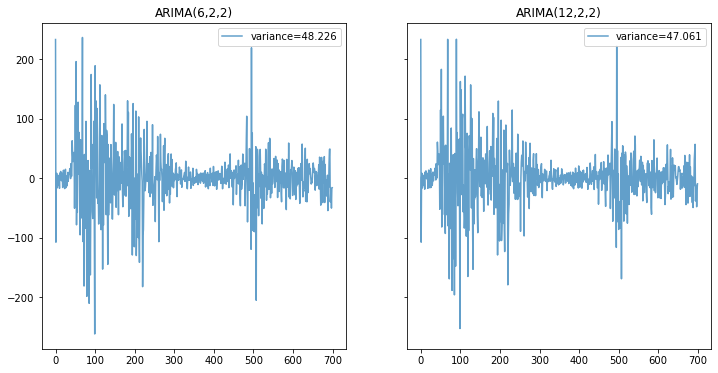

In [59]:
compareSummaryAndVariance((6,2,2), (12,2,2), fitted_timeseries)

The prediction:

/Users/stefanomartire/miniforge3/envs/lombacovid/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


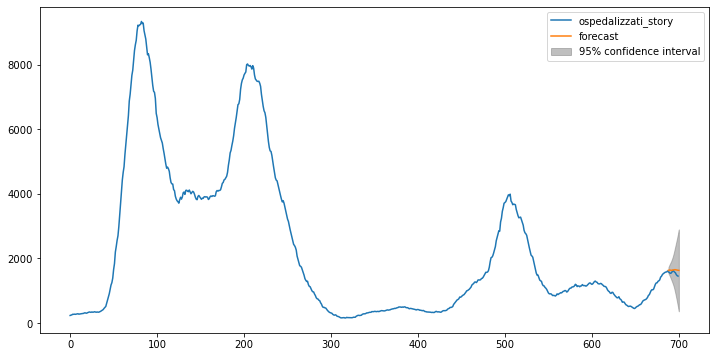

In [60]:
pred_len = 12

model = ARIMA(endog=fitted_timeseries[:-pred_len], order=(12,2,2))
result = model.fit()

fig, ax = plt.subplots(figsize=(12, 6))
fitted_timeseries.plot(ax=ax)

ax = plot_predict(result, start=len(fitted_timeseries.values)-pred_len, end=len(fitted_timeseries.values),
                    dynamic=True, plot_insample=False, ax=ax)

# SARIMA

In [61]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

We have to conduct some ADF tests on transformed data in order to stationarize the timeseries.

In [62]:
pred_len = 7

train_set = fitted_timeseries[:-pred_len]
test_set = fitted_timeseries[-pred_len:]

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.09834D+00    |proj g|=  2.29589D-01

At iterate    5    f=  5.03572D+00    |proj g|=  2.59847D-02

At iterate   10    f=  5.03317D+00    |proj g|=  1.49675D-02

At iterate   15    f=  5.03099D+00    |proj g|=  1.27887D-02

At iterate   20    f=  5.02597D+00    |proj g|=  7.82357D-02

At iterate   25    f=  5.02478D+00    |proj g|=  9.20654D-02

At iterate   30    f=  5.02208D+00    |proj g|=  7.84229D-02

At iterate   35    f=  5.02157D+00    |proj g|=  2.10500D-02

At iterate   40    f=  5.02107D+00    |proj g|=  1.86355D-02

At iterate   45    f=  5.01973D+00    |proj g|=  3.46843D-02


/Users/stefanomartire/miniforge3/envs/lombacovid/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  5.01805D+00    |proj g|=  5.42783D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   17     50     64      1     0     0   5.428D-02   5.018D+00
  F =   5.0180541904417657     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


Text(0.5, 1.0, 'SARIMA')

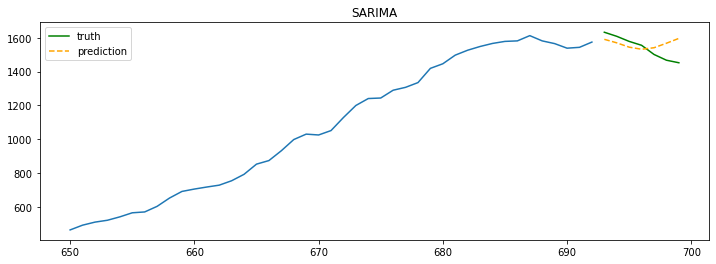

In [63]:
sarima_model = SARIMAX(train_set, order=(12,2,2), seasonal_order=(0, 1, 2, 12), enforce_invertibility=False, enforce_stationarity=False)
sarima_fit = sarima_model.fit()

sarima_pred = sarima_fit.get_prediction(len(fitted_timeseries.values)-pred_len+1, len(fitted_timeseries.values))
predicted_means = sarima_pred.predicted_mean

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(fitted_timeseries[650:-pred_len])
ax.plot(test_set, label='truth', color='green')
ax.plot(test_set.index, predicted_means, color='orange', linestyle='--', label="prediction")
ax.legend()
ax.set_title("SARIMA")